In [1]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingRegressor

warnings.filterwarnings('ignore') # 'once' shows warning just first time it is triggered
# We just use filterwarnings('ignore') to stop warnings from being sown for SKLEARN changes to defaults in upcoming versions

# We'll use boston housing data as an example
#bh = load_boston()
#target = bh.target
#x_data = bh.data

# We will evaluate the models using mean squared error
# Since Python's Sklearn requires scorer to have greater is better property
# We'll use the negated mean squared error as our scorer using make_scorer function
scorer = make_scorer(mean_squared_error, greater_is_better = False)

#Where applicable we'll use the same random seed
rand_state = 748932

# We'll pass an instance or repeatedstratified Kfold to the GridSearchCV
cv_strategy = KFold(n_splits = 10, shuffle = True, random_state = rand_state)
#cv_strategy = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rand_state)

## Preparing the Dataset 

Before we can build a model to predict the DW-Nominate scores for junionr legislators, we must first prepare our dataset. This section reads in the legislator and campaign finance data, join them, and cleans the data for downstream use in a machine learning model. 

In [6]:
# This reads the user data from Github
donationDataLocation = "https://raw.githubusercontent.com/zack-braun/DVA-Project/master/experiments/Donations%20to%20Cand%20by%20Committee.csv"
campaignDF = pd.read_csv(donationDataLocation)
campaignDF.rename({'Candidate_ID':'opensecrets'} , axis = 1, inplace = True)
campaignDF.fillna(0, inplace = True)
#display(campaignDF.sample(5))
#print('The campaign data has', campaignDF.shape[0], 'rows and', campaignDF.shape[1], 'columns')

# This reads in the legislator data
legislatorData = "https://raw.githubusercontent.com/zack-braun/DVA-Project/master/experiments/combinedData.csv"
legislatorDF = pd.read_csv(legislatorData)
legislatorDF['BirthYear'] = legislatorDF.date_of_birth.str.split("-", expand = True)[0]
dropColz = ['index', 'govtrack_id', 'congress', 'district', 'first_name', 'last_name','last_updated', 'date_of_birth',
            'short_title', 'missed_votes', 'middle_name', 'next_election', 'total_votes', 'total_present', 'at_large',
            'office', 'in_office', 'Finance', 'suffix', 'leadership_role', 'senate_class', 'state_rank', 
            'bioguide', 'ideaology']
legislatorDF.drop(dropColz , axis = 1, inplace = True)
#display(legislatorDF.sample(5))
#print('The legislator data has', legislatorDF.shape[0], 'rows and', legislatorDF.shape[1], 'columns')


combinedData = pd.merge(legislatorDF, campaignDF, on='opensecrets' , how="inner" )
combinedData.drop(['opensecrets'], axis = 1, inplace = True)
display(combinedData.sample(5))
print('The combined data has', combinedData.shape[0], 'rows and', combinedData.shape[1], 'columns')

target = combinedData['dw_nominate']
x_data = combinedData.copy()
x_data.drop(['dw_nominate'], axis = 1, inplace = True)

,dw_nominate,chamber,gender,missed_votes_pct,party,seniority,state,title,votes_with_party_pct,BirthYear,...,C90017708,C00647701,C00655696,C00473371,C00399865,C00676635,C00545616,C00031054,C00195065,C00679688
0,0.508,House,M,1.49,R,4,LA,Representative,97.48,1954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.549,House,M,1.01,R,2,KS,Representative,98.26,1956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,0.425,House,M,6.68,R,32,TX,Representative,98.76,1947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.648,House,M,0.08,R,8,MI,Representative,66.09,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,-0.449,House,M,7.84,D,6,CA,Representative,94.60,1941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The combined data has 547 rows and 4336 columns


## Building a Prediction Pipeline

DW-Nominate scores are continuous over their relevant range. Therefore, we will treat this as a regression problem and use several suitable machine learning approaches. As is common in regression problems, we will use cross-validated mean squared error to judge model performance.

Several of the models require that the input data is standardized. For these models we will use sklearn's prediction pipeline capabilities to ensure the standardization occurs as part of our cross-validated model tuning. For the remaining models we will use the un-standardized features in our model.In that case, we will use a different prediction pipeline.

In [7]:
numeric_features = list(x_data._get_numeric_data().columns)
categorical_features = list(x_data.columns.difference(numeric_features))

# We create seperate Pipelines for these columns
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer( transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])

# The final step is append the regression model to the prediction pipeline
# This will be handled in each section below

### Support Vector Regression (SVR) 

Support Vector Regression provides a alternative to regular regression. Rather than minimizing squared error as in standard OLS style regression, it is looking to minimize the error while allowing the fitted model to be less sensitive to errrors within a margin (typically referred to as epsilon). As discussed in our final report, past research has used SVR to predict DW-Nominate scores as a function of campaign finance data. Those methods involved the use of a large number of features indicating the amount of donations from different donors. We use similar methods to include the donations from different donors in our implementation of SVR, as well as the other models. We augment these features by also including demographic information about the candidate such as the gender, party, and other attributes.

Since SVR depends on distance calculations (just like support vector classification), the input features are all standardized during the model cross-validation pipeline.

In [8]:
predPipeSVR = Pipeline(steps = [('preprocessor', preprocessor), ('clf', SVR(gamma = 'scale'))])

# We need to tune the parameters c and kernel options:{'linear', 'poly', 'rbf', 'sigmoid'}
parameters = {'clf__kernel':('linear', 'rbf', 'poly'), 
              'clf__C':[0.01, 0.1, 1, 10, 100], 
              'clf__epsilon':[0.1, 0.3, 0.5, 0.9]}

clf = GridSearchCV(predPipeSVR, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsSVR = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)
# The best parameters searched are: {'clf__C': 0.1, 'clf__epsilon': 0.3, 'clf__kernel': 'linear'}

The best parameters searched are: {'clf__C': 0.1, 'clf__epsilon': 0.3, 'clf__kernel': 'linear'}


### Elastic Net Regresssion

Elastic Net regression uses a weighted average of the Lasso (L1) and Ridge (L2) penalties for regularization as shown in the formula below. 

$$\hat{\beta} = argmin\left( \left(y-X\beta\right)^2 + \lambda*\left(\alpha*\sum{\left|\beta\right|} + \left(1-\alpha\right)*\sum{\beta^2} \right) \right)$$

Both penalties trade bias in the coefficient estimates, which are shrunk toward zero, for reduced model variance, which can improve predictive accuracy. 

When $\alpha=1$ the penalty reduces to the usual Lasso (L1) penalty in terms of the absolute value of the coefficients. This has the effect that some coefficients are zeroed out or removed from the model, resulting in implicit feature selection. On the other hand $\alpha=0$ results in the Ridge (L2) penalty. Since the L2 penalty is a function of the squared coefficients, the individual coefficients are shrunk toward zero but not typically zeroed out. 

The code below tunes the optimal values for alpha (which sklearn call l1_ratio) and lambda (which sklearn confusingly calls alpha).

Since the penalties are a function of the coefficients and these in turn are affected by the scale of the data, each regressor is standardized prior to its inclusion in the model as was the case for the SVR model.



In [9]:
predPipeENET = Pipeline(steps = [('preprocessor', preprocessor), ('clf', ElasticNet(max_iter = 1500, 
                                                                                 random_state = rand_state))])

# Note: that sklearn's alpha penalty is the same as lambda in R's glmnet package
# thus, alpha controls strength of regularization
# Note: sklearn's l1_ratio is same as alpha in glmnet and controls mixing of l1 and l2 penalties
# l1_ratio = 1 runs straight Lasso, while l1_ratio = 0 runs straight ridge regression

parameters = {'clf__alpha':[0.1, 0.5, 1, 3, 5, 10, 100], 'clf__l1_ratio':[0,0.1, 0.25, 0.5, 0.75, 0.9, 1]}
clf = GridSearchCV(predPipeENET, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsENET = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)
#The best parameters searched are: {'clf__alpha': 0.1, 'clf__l1_ratio': 1}

The best parameters searched are: {'clf__alpha': 0.1, 'clf__l1_ratio': 1}


### Random Forest Regressor 

We can also fit a random forest regressor. This works similar to a random forest classification model, except the mean in each leaf is used for prediction.

The code below tunes the maximum number of features to consider for use in making a split, as well as the maximum depth of each tree.

Since the random forest model does not use distance in its optimization or penalties that are a function of the coefficients, it is not necessary to standardize the input features prior to fitting the model. However, we choose to apply the same preprocesser function the Random Forest model as was used to scale the other models.

In [11]:
predPipeRF = Pipeline(steps = [('preprocessor', preprocessor), 
                               ('clf', RandomForestRegressor(n_estimators = 750, random_state = rand_state) )])

parameters = {'clf__max_features':[5, 15, 25, 50, 100, 200, 300, 500], 'clf__max_depth':[5, 10, 15, 20, 30, 50, None]}
rfclf = GridSearchCV(predPipeRF, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
rfclf.fit(x_data, target)

resultsRFReg = rfclf.cv_results_

print('The best parameters searched are:', rfclf.best_params_)
#The best parameters searched are: {'clf__max_depth': 30, 'clf__max_features': 500}

The best parameters searched are: {'clf__max_depth': 30, 'clf__max_features': 500}


### Gradient Boosted Regression 

We will also try a boosted tree model. Gradient tree boosted regression fits successive regression models to residuals of the previous stage. The prediction function is essentially updated at each iteration as a weighted average of the previous predictive function (combination of trees previous trees) and the current iteration. The weighted combination is controlled by the learning rate. A smaller learning rate indicates that the new tree is given less weight when updating the aggregate prediction. There is a natural trade-off between the learning rate and number of estimators (n_estimators). Smaller learning rates, typically will combine with a larger number of iterations. This analysis uses a learning rate of 0.1 and iteratively fits 200 trees. 

In [12]:
predPipeGBR = Pipeline(steps = [('preprocessor', preprocessor),
                                ('clf', GradientBoostingRegressor(n_estimators = 200, random_state = rand_state,
                                                                 verbose = 1) )])

# We will optimize n_estimators, learning_rate, subsample, max_depth,
parameters = {  'clf__loss':['huber'], 'clf__learning_rate':[0.1],
                'clf__max_depth':[5, 10, 20, 30, 50], 'clf__subsample':[0.75, 0.85, 0.95],
                 'clf__max_features':['sqrt']}

clf = GridSearchCV(predPipeGBR, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsGBR = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)

#The best parameters searched are: {'clf__learning_rate': 0.1, 'clf__loss': 'huber', 
#'clf__max_depth': 50, 'clf__max_features': 'sqrt', 'clf__subsample': 0.75}

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0949           0.0227           19.46s
         2           0.0828           0.0129           19.08s
         3           0.0629           0.0142           19.20s
         4           0.0497           0.0117           19.04s
         5           0.0412           0.0090           18.68s
         6           0.0330           0.0074           18.76s
         7           0.0273           0.0062           18.68s
         8           0.0237           0.0035           18.70s
         9           0.0188           0.0045           18.63s
        10           0.0151           0.0036           18.51s
        20           0.0021           0.0004           17.29s
        30           0.0003           0.0000           16.16s
        40           0.0000           0.0000           14.95s
        50           0.0000           0.0000           13.61s
        60           0.0000           0.0000           12.13s
       

## Evaluating Model Performance

After tuning each of the regression models we use the cross-validation results to compare model performance. 

-  Step 1: Extract RMSE from each cross-validation fold for tuned model
-  Step 2: Visualize differences in model performance

If we had done repeated cross-validation or used a larger number of folds it would have been possible to perform pairwise T-tests to determine if the best performing model was statistically significantly better than the other models. We leave this excercise for future research.

SVR RMSE: [0.22722715 0.23689728 0.24111844 0.26870878 0.25864968 0.28628547
 0.34622652 0.22345364 0.29902676 0.26998553]
Elastic Net RMSE: [0.2097773  0.22116155 0.29113264 0.23694606 0.27368186 0.26302499
 0.25709182 0.25839708 0.34762817 0.21630336]
Random Forest RMSE: [0.09237444 0.09605247 0.1029708  0.10201619 0.1107296  0.11343094
 0.0945502  0.08629318 0.08738389 0.11303231]
Gradient Boosted Regression Tree RMSE: [0.11573918 0.1060807  0.14908582 0.13139263 0.15899624 0.1356035
 0.10396571 0.11506252 0.1098349  0.14594783]


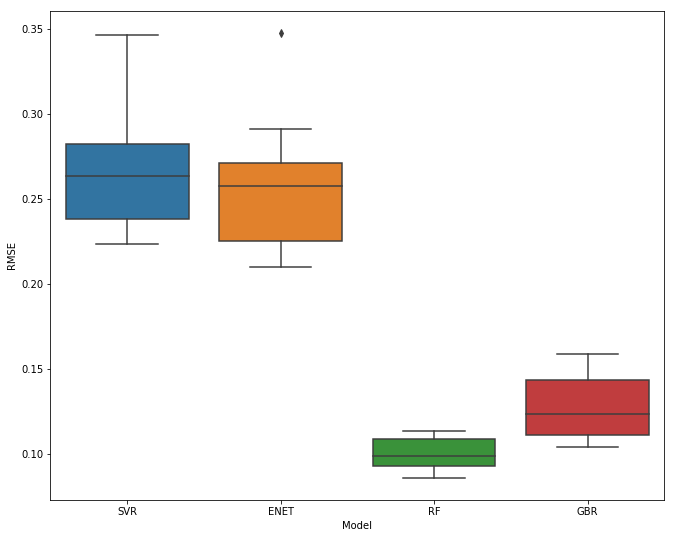

In [13]:
splitz = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
          'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score']

rmse = {}
# Get RMSE for SVR Model
minSVRScoreIdx = np.argmax(resultsSVR['mean_test_score'])
rmse['SVR'] = np.array([ np.sqrt(-resultsSVR[split][minSVRScoreIdx]) for split in splitz ])
print('SVR RMSE:', rmse['SVR'])

# Get RMSE for Elastic Net Model
minENETScoreIdx = np.argmax(resultsENET['mean_test_score'])
rmse['ENET'] = np.array([ np.sqrt(-resultsENET[split][minENETScoreIdx]) for split in splitz ])
print('Elastic Net RMSE:', rmse['ENET'])

# Get RMSE for Random Forest Regression Model
minRFRegScoreIdx = np.argmax(resultsRFReg['mean_test_score'])
rmse['RF'] = np.array([ np.sqrt(-resultsRFReg[split][minRFRegScoreIdx]) for split in splitz ])
print('Random Forest RMSE:', rmse['RF'])

# Get RMSE for Gradient Boosted Regression Tree
minGBRScoreIdx = np.argmax(resultsGBR['mean_test_score'])
rmse['GBR'] = np.array([ np.sqrt(-resultsGBR[split][minGBRScoreIdx]) for split in splitz ])
print('Gradient Boosted Regression Tree RMSE:', rmse['GBR'])



rmse_df = pd.DataFrame(rmse)
rmse_df['Fold'] = rmse_df.index + 1
rmse_df_long = pd.melt(rmse_df, id_vars = ['Fold'], var_name = 'Model', value_name = 'RMSE')
#f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.boxplot( x = 'Model', y = 'RMSE', data = rmse_df_long)
fig = ax.get_figure()
fig.savefig("C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/ProjectpredJuniorLegisDW.png")

Based on this example code we can conclude that the Elastic Net model had the worst out of sample performance and is probably not the best candidate for use. The Support Vector Regression did slightly better. Past literature had used Support Vector Regression to predict legislator DW-Nominate scores using campaign finance data; however, the Gradient Boosted Regression Tree and Random Forest models both outperformed this model. These are both algorithms that could be useful to other researchers working on this topic in the future. The Random Forest model ultimately had the best average predictive performance and a narrower RMSE variance across the out-of-sample folds.

Given its quick time to fit and predictive performance, the Random Forest Regression seems like a good candidate to use.

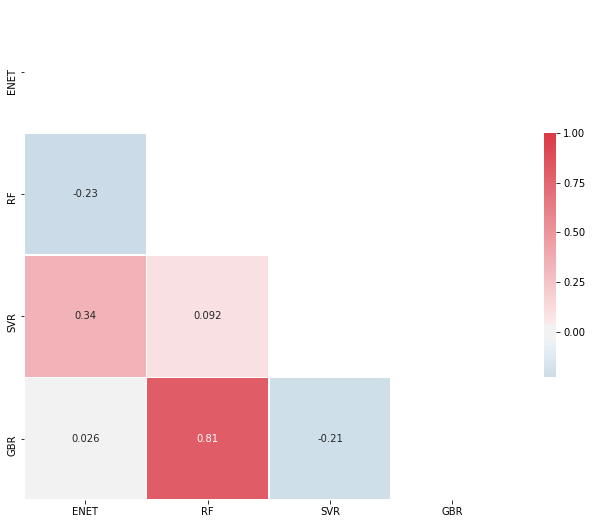

In [14]:

corr = rmse_df[['ENET', 'RF', 'SVR', 'GBR']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, n=9, as_cmap = True)
f, ax = plt.subplots(figsize=(11, 9))


display(sns.heatmap(corr, cmap=cmap, mask = mask, vmax=1, center=0, square=True, 
                    linewidths=.5, annot=True, cbar_kws={"shrink": .5}))

Given that the models are relatively uncorrelated (with the exception of the support vector regression and elastic net), we can probably improve accuracy by averaging our predictions. It has been shown that Elastic Net and Support Vector Regression are related. Since most of the models errors aren't heavily correlated, we choose to try a stacked model to aggregate the predictions and see if it improves the predictive performance.

In [15]:
warnings.filterwarnings('ignore') # 'once' shows warning just first time it is triggered

predPipeRF = Pipeline(steps = [('preprocessor', preprocessor), 
                                ('clf', RandomForestRegressor(n_estimators= 1000, max_features = 500, 
                                                              max_depth = 30, random_state = rand_state))])

predPipeENET = Pipeline(steps = [('preprocessor', preprocessor), 
                                 ('clf', ElasticNet(max_iter = 1500, alpha = 0.1, 
                                                    l1_ratio = 1, random_state = rand_state))])

predPipeGBR = Pipeline(steps = [('preprocessor', preprocessor),
                                ('clf', GradientBoostingRegressor(n_estimators = 200, random_state = rand_state,
                                                                 learning_rate = 0.1, max_features = 'sqrt', 
                                                                 subsample = 0.75, max_depth = 50, loss = 'huber') )])

predPipeSVR = Pipeline(steps = [('preprocessor', preprocessor), 
                                ('clf', SVR(gamma = 'scale', C = 0.1, epsilon = 0.3, kernel = 'linear'))])

rfStack = RandomForestRegressor(n_estimators = 500, random_state = rand_state, max_features = 'auto')

regressors = [predPipeRF, predPipeENET, predPipeGBR, predPipeSVR]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=rfStack)

parameters = {'meta-randomforestregressor__max_depth':[1, 3, 5, None]}



grid = GridSearchCV(estimator=stregr, param_grid=parameters, scoring = scorer, cv=cv_strategy)
grid.fit(x_data, target)

resultsStack = grid.cv_results_

minStackScoreIdx = np.argmax(resultsStack['mean_test_score'])
rmse['Stack'] = np.array([ np.sqrt(-resultsStack[split][minStackScoreIdx]) for split in splitz ])
print('Stacked Models:', rmse['Stack'])

Stacked Models: [0.10830503 0.10745868 0.1331932  0.12167784 0.14406623 0.12218015
 0.10035428 0.11322675 0.10609487 0.14087484]


As we can see in the chart below, after stacking the models there is a slight improvement in root mean square error relative to the Gradient Boosted Regression Tree model; however, we aren't able to outperform the Random Forest model. Therefore, we elect to use the results of this modeling approach.

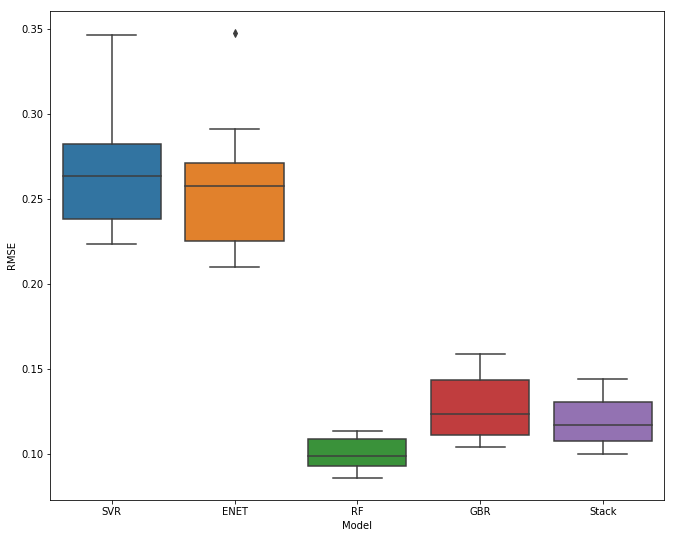

In [16]:

rmse_df = pd.DataFrame(rmse)
rmse_df['Fold'] = rmse_df.index + 1
rmse_df_long = pd.melt(rmse_df, id_vars = ['Fold'], var_name = 'Model', value_name = 'RMSE')
#f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.boxplot( x = 'Model', y = 'RMSE', data = rmse_df_long)
fig = ax.get_figure()
fig.savefig("C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/Project/predJuniorLegisDWStackedFinal.png")

In [17]:
#missingDWNominateFile = "C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/Project/missingDW.csv"
missingDWNominateFile = "https://raw.githubusercontent.com/zack-braun/DVA-Project/master/experiments/missingDW.csv"
missingDW = pd.read_csv(missingDWNominateFile)
missingDW.drop(['Unnamed: 0', 'dw_nominate'], axis = 1, inplace = True )

missingDW = pd.merge(missingDW, campaignDF, on='opensecrets' , how="left" )

missingDW.drop(['opensecrets', 'govtrack_id'], axis = 1, inplace = True)
missingDW = missingDW.fillna(0, axis = 1)
display(missingDW.head())


,chamber,gender,missed_votes_pct,party,seniority,state,title,votes_with_party_pct,BirthYear,C00173393,...,C90017708,C00647701,C00655696,C00473371,C00399865,C00676635,C00545616,C00031054,C00195065,C00679688
0,House,M,0.86,R,2,OH,Representative,100.00,1962,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,House,F,0.00,D,16,GU,Delegate,0.00,1933,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,House,M,0.00,R,2,TX,Representative,95.16,1975,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,House,F,0.00,R,2,PR,Resident Commissioner,0.00,1976,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,House,M,0.00,R,2,OK,Representative,97.62,1961,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# We make our predictions with the RF model
predictedDW = rfclf.predict(missingDW)



display(predictedDW)
DWNom = pd.Series(predictedDW)
missingDW['dw_nominate'] = DWNom
missingDW.to_csv('C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/Project/missingDWpredictionsFinal.csv')

array([ 0.43571434, -0.34941749,  0.61175969,  0.47391191,  0.5309464 ,
       -0.33869272, -0.438044  , -0.37518259,  0.48750696, -0.37593478,
       -0.33284457, -0.31910814,  0.48089045])